# Stereovision

![Suzanne](main.png)

Stereovision is a discipline that deals with the reconstruction of 3D information from images. For the reconstruction of a point, several images of this point are needed. These images must be taken from different points of view. The key step of the reconstruction, which is often problematic, is to identify the images of the point to be reconstructed in each view.

## Epipolar Geometry

Epipolar geometry involves two cameras. The epipolar geometry describes the geometric properties between two views of the same scene and depends only on the intrinsic parameters of the cameras and their relative positions. It provides, in particular, the epipolar constraint, which will be very useful to produce the matches between views.

## The Fondamental Matrix

![Epipolar Geometry - Sanyam Kapoor](epipolar.png)

Let us imagine that we have two images, right and left, of the world space. Let's take a point $\vec{x}$ in the right image space. The point $\vec{X}$ of the world space, of which $\vec{x}$ is the image, can be anywhere on the line passing through $\vec{x}$ and the optical center of the right camera. We will call this line the back-projected ray of $\vec{x}$. Let us note $\vec{x}'$ the image of $\vec{X}$ in the left image space. The locus of $\vec{x}'$ is therefore the image line of the back-projected ray of $\vec{x}$. This line is called the epipolar line and is denoted $\vec{l}'$. The epipolar line passes through the epipole $\vec{e}'$, image of the optical center of the right camera.

In 2D projective geometry, a line with equation $ax+by+c = 0$ is represented by a vector with three components $(a, b, c)^T$ defined to within one factor. Thus, we have the following relationship:

>The point $\vec{x}$ belongs to the line $\vec{l}$ if and only if $x^T\vec{l} = 0$.

Moreover, in 2D projective geometry, the following remarkable relations are valid:

- The intersection of two lines $l$ and $l'$ is given by $x = l \times l'$,
- The line passing through two points $x$ and $x'$ is given by $l = x \times x'$.

Note that the vector product can be written as a product of matrix $x \times y = [x]_\times y$ where

$$[x]_\times = \begin{pmatrix} 0 & −x3 & x2 \\ x3 & 0 & −x1 \\ −x2 & x1 & 0 \end{pmatrix}$$

To find the equation of the epipolar line in the left image space, we just need to find the coordinates of two points of this line. The first is the image $P'\vec{C}$ of the optical center $\vec{C}$ of the right camera where $P'$ is the projection matrix of the left camera. The second is $P'P^{+}\vec{x}$ where $P^{+}$ is the pseudo inverse of the projection matrix $P$ of the right camera. The epipolar line thus has the equation $l' = [P'\vec{C}]_\times{}P'P^{+}\vec{x} = F\vec{x}$ with $F = [P'\vec{C}]_\times{}P'P^{+}$. $F$ is called fundamental matrix.

Since the epipolar line $\vec{l}' = F\vec{x}$ is the locus of $\vec{x}'$, $\vec{x}'$ therefore belongs to $\vec{l}'$ which leads to the epipolar constraint :

>**The fundamental matrix is such that for any pair of points corresponding $\vec{x} \leftrightarrow \vec{x}'$ in the two images, we have $\vec{x}'^{T}F\vec{x} = 0$.**

## Computation of the fundamental matrix

The fundamental matrix $F$ has seven degrees of freedom. It has nine components but these are defined to within one scale factor, which removes one degree of freedom. Moreover, the matrix $F$ is a singular matrix ($det(F) = 0$) which gives us seven degrees of freedom. So we need at least seven correspondences to compute $F$. The equation $x'^{T}_iFx_i = 0$ and the seven correspondences allow us to write a system of equations of the form $Af = 0$, where $f$ is the vector which contains the components of the matrix $F$. Let us assume that $A$ is a 7×9 matrix of rank 7. The general solution of $Af = 0$ can be written $\alpha f_1 + (1-\alpha) f_2$ where $f_1$ and $f_2$ are two particular independent solutions of $Af = 0$. We then use the singularity constraint $det(\alpha F_1 + (1 - \alpha)F_2) = 0$ to determine $\alpha$. Since the singularity constraint gives rise to a third degree equation, we may have one or three solutions for $F$.

## OpenCV

In practice you will use the OpenCV library. In python, you have access to its functions through the `cv2` module.

You can find help with the calibration and reconstruction functions on the site https://docs.opencv.org/4.0.0/d9/d0c/group__calib3d.html

## Goal

In the zip of the statement you will find two sequences of images taken by two cameras during the scanning of an object by a laser plane.

![Laser](scanRight/scan0010.png)

You will also find shots of a checkerboard in different positions that will help you calibrate your cameras.

![Damier](chessboards/c2Right.png)

The goal is to reconstruct the scanned object in 3D.

In [1]:
### Imports and image loading ###
# https://docs.opencv.org/3.4/dc/dbb/tutorial_py_calibration.html
# https://learnopencv.com/camera-calibration-using-opencv/

# Importing the libraries
from matplotlib import pyplot as plt
import numpy as np
import cv2 as cv
import glob

# Loading the chessboard images
chessboardRight = glob.glob('chessboards/c*Right.png')
chessboardLeft = glob.glob('chessboards/c*Left.png')


# Loading the scan images
scanRight = glob.glob('scanRight/*.png')
scanLeft = glob.glob('scanLeft/*.png')

- We can use the function glob.glob() or glob.iglob() directly from glob module
  to retrieve paths recursively from inside the directories/files and subdirectories/subfiles.

In [2]:
### Constants and variables ###

# Chessboard size
chessboardSize = (7, 7)
chessboardSquareSize = chessboardSize[0] * chessboardSize[1]

# Termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# world coordinates (object points)
# like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((chessboardSquareSize, 3), np.float32)
objp[:, :2] = np.mgrid[0:chessboardSize[0], 0:chessboardSize[1]].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = []      # 3d point in real world space
imgpointsL = []     # 2d points in image plane.
imgpointsR = []     # 2d points in image plane.

# Image shape
grayShape = cv.cvtColor(cv.imread(chessboardRight[0]), cv.COLOR_BGR2GRAY).shape[::-1]

- The 7x7 ChessboardSize corresponds to the number of Corners to consider  

- numpy.zeros(shape, dtype=float, order='C', *, like=None)  
  
  
    - Shape of the new array, e.g., (2, 3) or 2.  
    
    - The desired data-type for the array, e.g., numpy.int8. Default is numpy.float64.  
  
  
- Here's an example of the output of the 'objp' matrix :



In [3]:
print(objp[:10])

[[0. 0. 0.]
 [1. 0. 0.]
 [2. 0. 0.]
 [3. 0. 0.]
 [4. 0. 0.]
 [5. 0. 0.]
 [6. 0. 0.]
 [0. 1. 0.]
 [1. 1. 0.]
 [2. 1. 0.]]


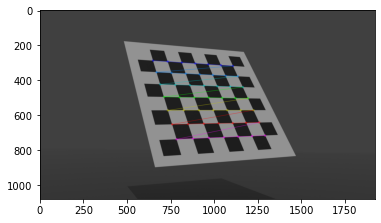

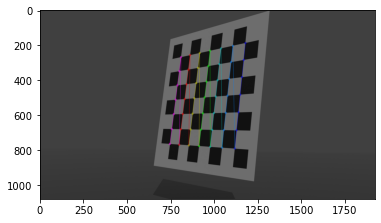

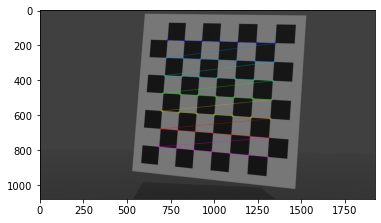

[[2.09914918e+03 0.00000000e+00 9.60351418e+02]
 [0.00000000e+00 2.09921602e+03 5.39167358e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[2.09989415e+03 0.00000000e+00 9.59679787e+02]
 [0.00000000e+00 2.09976405e+03 5.39414215e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [19]:
### Calibration ###

for image in chessboardLeft:
    img = cv.imread(image)
    grayLeft = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    #find the chess board corners
    ret, corners = cv.findChessboardCorners(grayLeft, (7,7), None)
    if ret == True:
        corners = cv.cornerSubPix(grayLeft, corners, (11,11), (-1,-1), criteria)
        imgpointsL.append(corners)
        objpoints.append(objp)
        # Draw and display the corners
        # cv.drawChessboardCorners(img, chessboardSize, corners, ret)
        # plt.imshow(img)
        # plt.show()

for image in chessboardRight:
    img = cv.imread(image)
    grayRight = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    #find corners the chess board corners
    ret, corners = cv.findChessboardCorners(grayRight, (7,7), None)
    if ret == True:
        corners = cv.cornerSubPix(grayRight, corners, (11,11), (-1,-1), criteria)
        imgpointsR.append(corners)
        # Draw and display the corners
        cv.drawChessboardCorners(img, chessboardSize, corners, ret)
        plt.imshow(img)
        plt.show()

# Calibrate the cameras, mtxl = matrice intrinseques, distl = distortion coefficients,
# rvecsl = rotation vectors, tvecsl = translation vectors
ret, mtxL, distL, rvecsL, tvecsL = cv.calibrateCamera(objpoints, imgpointsL, grayShape, None, None)
ret, mtxR, distR, rvecsR, tvecsR = cv.calibrateCamera(objpoints, imgpointsR, grayShape, None, None)


# stereo calibration
# Calibrates a stereo camera set up. This function finds the intrinsic parameters 
# for each of the two cameras and the extrinsic parameters between the two cameras.
ret, mtxL, distL, mtxR, distR, R, T, E, F = cv.stereoCalibrate(objpoints,
                                                               imgpointsR,
                                                               imgpointsL,
                                                               mtxR,
                                                               distR,
                                                               mtxL,
                                                               distL,
                                                               grayShape)



- The centers of the Cameras are respectively :

In [20]:
Left_Camera_Center = (mtxL[0][2], mtxL[1][2])
print(Left_Camera_Center)

(959.6797869758647, 539.4142148899263)


In [21]:
Right_Camera_Center = (mtxR[0][2], mtxR[0][2])
print(Right_Camera_Center)

(960.3514184942012, 960.3514184942012)


- Also, this is the result for the Camera's fundamental matrix 'F' :

In [22]:
print(F)

[[-3.90753630e-08  1.07439343e-06 -8.66666522e-04]
 [ 7.61987112e-07  4.22280706e-08  1.07975272e-02]
 [-1.85577892e-04 -1.24961147e-02  1.00000000e+00]]


In [38]:
# Isolate the red line on scan image
def isolateRedLine(img):
    # Convert to HSV (hue, saturation, value)
    img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    # Define lower and upper limits of what we call "red"
    lower_red = np.array([0, 100, 100])
    upper_red = np.array([10, 255, 255])
    # Threshold the HSV image to get only red colors
    # mask is a np array of (1080, 1920)
    mask = cv.inRange(img_hsv, lower_red, upper_red)
    mask = np.clip(mask, 0, 255)
    return mask


# Get the coordinates of the red line
def getRedLineCoordinates(img):
    # Isolate the red line
    redLine = isolateRedLine(img)
    points = []
    for count, line in enumerate(redLine):
        for pixel in line:
            if pixel != 0:
                pixel = 1
        try:
            # get the central pixel (for every lines with Red pixel in it) 
            # of the Red line by averaging over the coordinates 
            points.append([np.average(range(1920), weights = line), count])
        except:
            pass
    return points



# Get the epiline from the coordinates of the red line
def getEpiline(img, direction):
    # Convert to grayscale
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # get the coordinates
    coordinates = np.array(getRedLineCoordinates(img), dtype=np.float32)
    lines = []
    if coordinates.size != 0:
        # Find the epilines
        # Output vector of the epipolar lines corresponding to the points 
        # in the other image. Each line ax + by + c = 0 is encoded by 3 numbers (a,b,c).
        lines = cv.computeCorrespondEpilines(coordinates, direction, F)
        lines = lines.reshape(-1, 3)
    return lines, coordinates

Reconstruction_points_Left = []
Reconstruction_Epilines_Right = []
Reconstruction_points_Right = []
Reconstruction_Epilines_Left = []

for i in range(0, len(scanLeft)):
    imageLeft = scanLeft[i]
    imageRight = scanRight[i]
    imgL = cv.imread(imageLeft)
    imgR = cv.imread(imageRight)
    try:
        epilinesR, pointsL = getEpiline(imgL, 1)
        epilinesL, pointsR = getEpiline(imgR, 2)
        if pointsL.size > 0:
            Reconstruction_Epilines_Right.append(epilinesR)
            Reconstruction_points_Left.append(pointsL[:])
        if pointsR.size > 0:
            Reconstruction_points_Right.append(pointsR[:])
            Reconstruction_Epilines_Left.append(epilinesL)
    except:
        pass
    #epilinesL, pointsR = getEpiline(imgR, 2)

    # Here we only draw the 12th image
    if i == 12:
        # draw every 40 points
        for i in range(0,len(pointsL),40):
            cv.circle(imgL, (int(pointsL[i][0]), int(pointsL[i][1])), 5, (255, 0, 0), -1)
            # draw the epiline
            a, b ,c = epilinesR[i]
            cv.line(imgR, (0, -int(c/b)), (1920, -int((c+a*1920)/b)), (255, 0, 0), 2)
        for i in range(0,len(pointsR),40):    
            cv.circle(imgR, (int(pointsR[i][0]), int(pointsR[i][1])), 5, (0, 255, 0), -1)
            a, b ,c = epilinesL[i]
            cv.line(imgL, (0, -int(c/b)), (1920, -int((c+a*1920)/b)), (0, 255, 0), 2)
        # subplot
        fig, (ax1, ax2) = plt.subplots(1, 2)
        # define the size of the figure
        fig.set_size_inches(18.5, 10.5)
        ax1.imshow(imgL)
        ax2.imshow(imgR)
        plt.show()

- TODO:
    - Construct the corresponding lines based on the points and the center of the cameras
    - Find the intersection of each corresponding lines, this intersection point is the Real Space Point
    - Plot these points